In [1]:
import numpy as np
from numpy.random import random, choice
import matplotlib.pyplot as plt
%matplotlib inline

import gym

In [2]:
env = gym.make('FrozenLake-v0', is_slippery=True)

In [3]:
print("Action space = ", env.action_space)
print("Observation space = ", env.observation_space)

Action space =  Discrete(4)
Observation space =  Discrete(16)


In [4]:
actionsDict = {}
actionsDict[0] = "  L  "
actionsDict[1] = "  D  "
actionsDict[2] = "  R  "
actionsDict[3] = "  U  "

actionsDictInv = {}
actionsDictInv["L"] = 0
actionsDictInv["D"] = 1
actionsDictInv["R"] = 2
actionsDictInv["U"] = 3

In [5]:
env.reset()
env.render()


SFFF
FHFH
FFFH
HFFG


In [6]:
optimalPolicy = ["L/D/R","  U  ","  U  ","  U  ",
                 "  L  ","  -  "," L/R ","  -  ",
                 "  U  ","  D  ","  L  ","  -  ",
                 "  -  ","  R  ","  D  ","  !  "]
    
print("Optimal policy:")
idxs = [0,4,8,12]
for idx in idxs:
    print(optimalPolicy[idx+0], optimalPolicy[idx+1], 
          optimalPolicy[idx+2], optimalPolicy[idx+3])

Optimal policy:
L/D/R   U     U     U  
  L     -    L/R    -  
  U     D     L     -  
  -     R     D     !  


In [7]:
def action_epsilon_greedy(q, s, epsilon=0.05):
    if np.random.rand() > epsilon:
        return np.argmax(q[s])
    return np.random.randint(4)

def get_action_epsilon_greedy(epsilon):
    return lambda q,s: action_epsilon_greedy(q, s, epsilon=epsilon)

In [8]:
def greedy_policy(q, s):
    return np.argmax(q[s])

In [9]:
def average_performance(policy_fct, q):
    acc_returns = 0.
    n = 500
    for i in range(n):
        done = False
        s = env.reset()
        while not done:
            a = policy_fct(q, s)
            s, reward, done, info = env.step(a)
            acc_returns += reward
    return acc_returns/n

In [10]:
# parameters for sarsa(lambda)
episodes = 80000
STEPS = 2000
gamma = 1
alpha = 0.02
epsilon_start = 0.2
epsilon_end = 0.001
epsilon_annealing_stop = int(episodes/2)
eligibility_decay = 0.3

In [11]:
q = np.ones((16, 4))
# Set q(terminal,*) equal to 0
q[5,:] = 0.0
q[7,:] = 0.0
q[11,:] = 0.0
q[12,:] = 0.0
q[15,:] = 0.0
performance = np.ndarray(episodes//STEPS)

In [12]:
for episode in range(episodes):

    inew = min(episode,epsilon_annealing_stop)
    epsilon = (epsilon_start * (epsilon_annealing_stop - inew) + epsilon_end * inew) / epsilon_annealing_stop
    
    E = np.zeros((16, 4))
    
    state = env.reset()
    action = action_epsilon_greedy(q, state, epsilon)

    while True:

        E = eligibility_decay * gamma * E
        E[state, action] += 1

        new_state, reward, done, info = env.step(action)
        
        new_action = action_epsilon_greedy(q, new_state, epsilon)

        delta = reward + gamma * q[new_state, new_action] - q[state, action]
        q = q + alpha * delta * E 

        state, action = new_state, new_action

        if done:
            break

    # only for plotting the performance, not part of the algorithm 
    if episode%STEPS == 0:
        performance[episode//STEPS] = average_performance(get_action_epsilon_greedy(epsilon), q=q)

Text(0, 0.5, 'Average reward of an epoch')

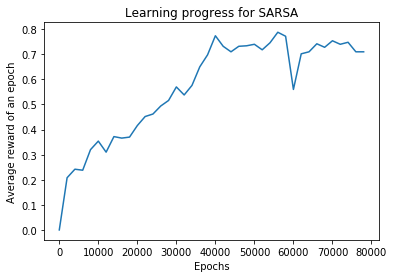

In [13]:
plt.plot(STEPS*np.arange(episodes//STEPS), performance)
plt.xlabel("Epochs")
plt.title("Learning progress for SARSA")
plt.ylabel("Average reward of an epoch")

In [14]:
greedyPolicyAvgPerf = average_performance(greedy_policy, q=q)
print("Greedy policy SARSA performance =", greedyPolicyAvgPerf) 

Greedy policy SARSA performance = 0.734


In [15]:
q = np.round(q,3)
print("(A,S) Value function =", q.shape)
print("First row")
print(q[0:4,:])
print("Second row")
print(q[4:8,:])
print("Third row")
print(q[8:12,:])
print("Fourth row")
print(q[12:16,:])

(A,S) Value function = (16, 4)
First row
[[0.795 0.781 0.79  0.786]
 [0.426 0.386 0.319 0.793]
 [0.511 0.535 0.541 0.795]
 [0.341 0.416 0.393 0.796]]
Second row
[[0.794 0.515 0.541 0.519]
 [0.    0.    0.    0.   ]
 [0.321 0.211 0.469 0.125]
 [0.    0.    0.    0.   ]]
Third row
[[0.5   0.514 0.595 0.788]
 [0.584 0.778 0.525 0.46 ]
 [0.703 0.54  0.462 0.365]
 [0.    0.    0.    0.   ]]
Fourth row
[[0.    0.    0.    0.   ]
 [0.563 0.557 0.862 0.508]
 [0.823 0.94  0.878 0.863]
 [0.    0.    0.    0.   ]]


In [16]:
policyFound = [actionsDict[np.argmax(q[0,:])],actionsDict[np.argmax(q[1,:])],actionsDict[np.argmax(q[2,:])],actionsDict[np.argmax(q[3,:])],
               actionsDict[np.argmax(q[4,:])],"  -  ",actionsDict[np.argmax(q[6,:])],"  -  ",
               actionsDict[np.argmax(q[8,:])],actionsDict[np.argmax(q[9,:])],actionsDict[np.argmax(q[10,:])],"  -  ",
               "  -  ",actionsDict[np.argmax(q[13,:])],actionsDict[np.argmax(q[14,:])],"  !  "]
print("Greedy policy found:")
idxs = [0,4,8,12]
for idx in idxs:
    print(policyFound[idx+0], policyFound[idx+1], 
          policyFound[idx+2], policyFound[idx+3])

print(" ")

print("Optimal policy:")
idxs = [0,4,8,12]
for idx in idxs:
    print(optimalPolicy[idx+0], optimalPolicy[idx+1], 
          optimalPolicy[idx+2], optimalPolicy[idx+3])

Greedy policy found:
  L     U     U     U  
  L     -     R     -  
  U     D     L     -  
  -     R     D     !  
 
Optimal policy:
L/D/R   U     U     U  
  L     -    L/R    -  
  U     D     L     -  
  -     R     D     !  
